In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import meshio
from torch_geometric.data import Data

In [2]:
class DNN(nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        modules = []
        for i in range(len(layers) - 2):  # Exclude last layer for activation
            modules.append(nn.Linear(layers[i], layers[i+1]))
            modules.append(nn.Tanh())
        modules.append(nn.Linear(layers[-2], layers[-1]))  # Last layer (no activation)
        self.network = nn.Sequential(*modules)

    def forward(self, x):
        return self.network(x)

In [3]:
nodes = 64
layers = [2] + 6 * [nodes] + [5]

weights = "models/baseline_model_6_64.pth"

In [4]:
model = DNN(layers)
model.load_state_dict(torch.load(weights, weights_only=True))

<All keys matched successfully>

In [5]:
data_file = "meshes/hole_middle_r10_al.csv"
mesh_file = "meshes/hole_middle_r10_o1.inp"

mesh = meshio.read(mesh_file)
df = pd.read_csv(data_file, sep=",", skipinitialspace=True)

In [6]:
von_miss = df["Equivalent Stress"].values
nodes = mesh.points[:,:2]
a = len(nodes)
node_features = torch.tensor(von_miss[:a], dtype=torch.float).view(-1, 1)

print(len(nodes))

print(len(node_features[:a]))

5529
5529


In [7]:
edges = []
for cell in mesh.cells:
    if cell.type == "triangle":
        for element in cell.data:
            edges.append([element[0], element[1]])
            edges.append([element[1], element[0]])

            edges.append([element[1], element[2]])
            edges.append([element[2], element[1]])

            edges.append([element[2], element[0]])
            edges.append([element[0], element[2]])

edges = torch.tensor(edges, dtype=torch.long).t().contiguous()
pos = torch.tensor(nodes, dtype=torch.float)

data = Data(x=node_features, edge_index=edges, pos=pos)
print(data.x.shape)
print(data.pos.shape)

torch.Size([5529, 1])
torch.Size([5529, 2])


In [8]:
x = pos[:, 0:1].detach().cpu().numpy()
y = pos[:, 1:2].detach().cpu().numpy()

x = torch.tensor(x, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float)
input = torch.cat((x, y), dim=1)

out = model(input)
out = out.detach().cpu().numpy()
u = out[:,0:1]
v = out[:,1:2]
sxx = out[:,2:3]
syy = out[:,3:4]
sxy = out[:,4:5]

E = 7e10  # Young's modulus (Pa)
sigma_0 = 50e6  # Applied stress (Pa)

U = sigma_0 / E

u = u*U
v = v*U
sxx = sxx*sigma_0
syy = syy*sigma_0
sxy = sxy*sigma_0
von_mises = np.sqrt(sxx**2 + syy**2 - sxx*syy + 3*sxy**2)
fem_von = node_features.detach().cpu().numpy()

In [9]:
l2_error = np.linalg.norm(von_mises - fem_von) / np.linalg.norm(fem_von, 2)
print(l2_error)

0.02185554


In [11]:
import matplotlib.tri as tri
import matplotlib.ticker as ticker
from matplotlib import rcParams

In [26]:
rcParams.update({
    'font.size': 20,
    'axes.titlesize': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
})

In [24]:
triang = tri.Triangulation(x.flatten(), y.flatten())

x_tri = x.flatten()[triang.triangles].mean(axis=1)
y_tri = y.flatten()[triang.triangles].mean(axis=1)

hole_center = (1.0, 0.5)
hole_radius = 0.10

mask = (x_tri - hole_center[0])**2 + (y_tri - hole_center[1])**2 < hole_radius**2
triang.set_mask(mask)

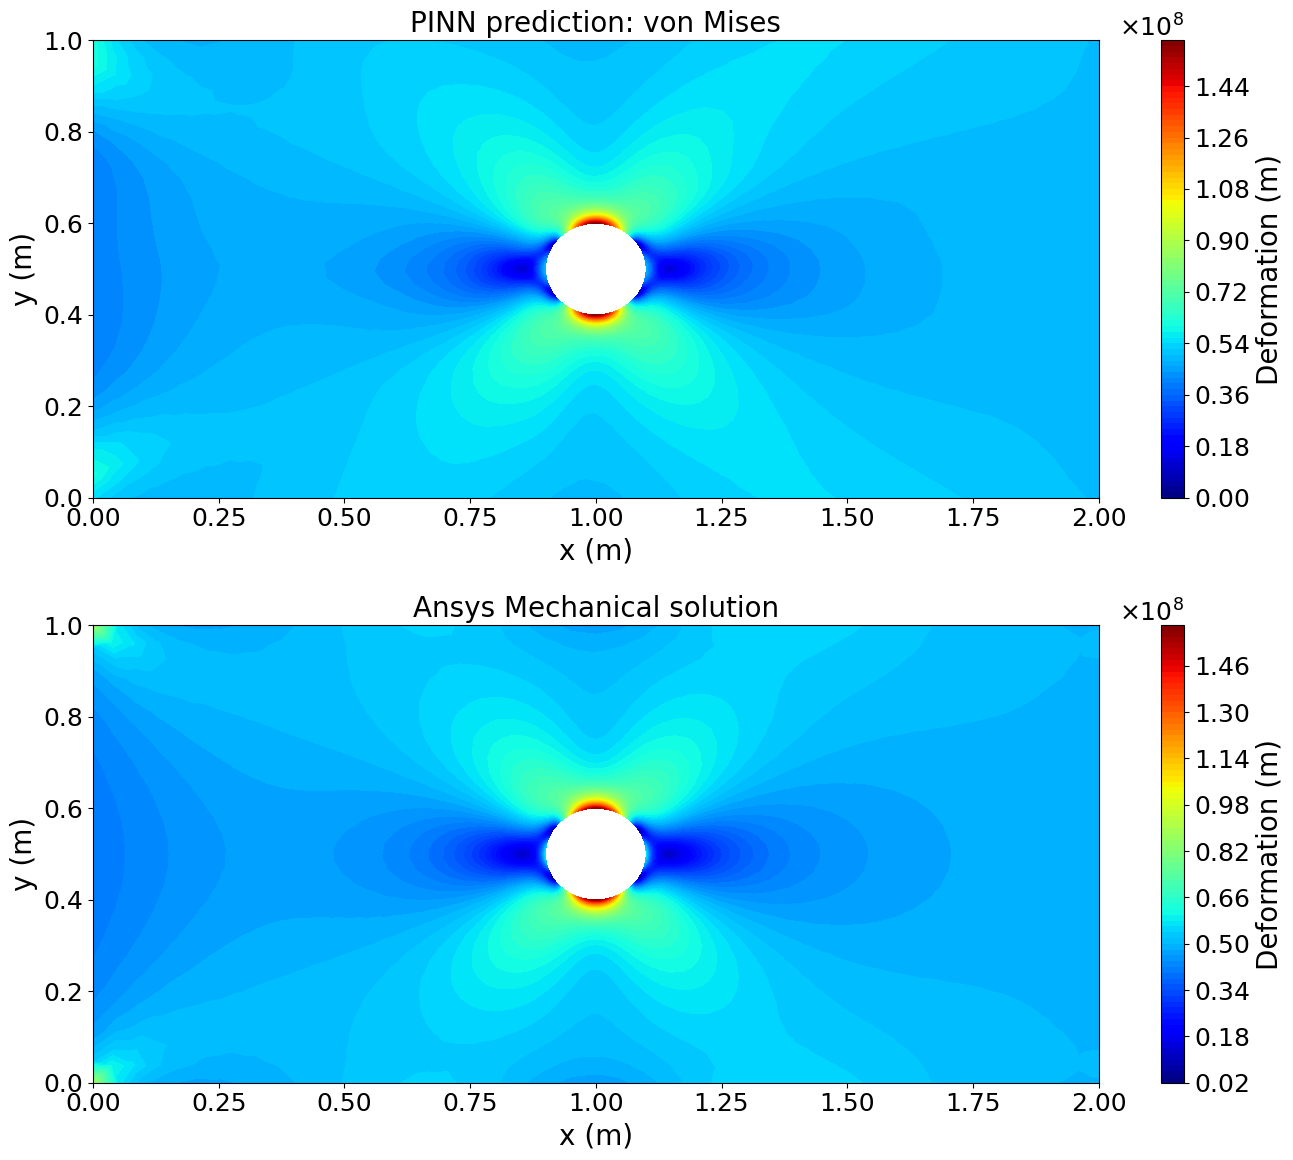

In [27]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

color_map = 'jet'

sc1 = ax1.tricontourf(triang, von_mises.flatten(), levels = 100, cmap='jet')
ax1.set_title('PINN prediction: von Mises')
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")
cb1 = plt.colorbar(sc1)
cb1.set_label("Deformation (m)")

sc2 = ax2.tricontourf(triang, fem_von.flatten(), levels = 100, cmap='jet')
ax2.set_title('Ansys Mechanical solution')
ax2.set_xlabel("x (m)")
ax2.set_ylabel("y (m)")
cb2 = plt.colorbar(sc2)
cb2.set_label("Deformation (m)")

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-2, 2))  # Show sci notation for numbers < 1e-2 or > 1e2
cb1.ax.yaxis.set_major_formatter(formatter)
cb2.ax.yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

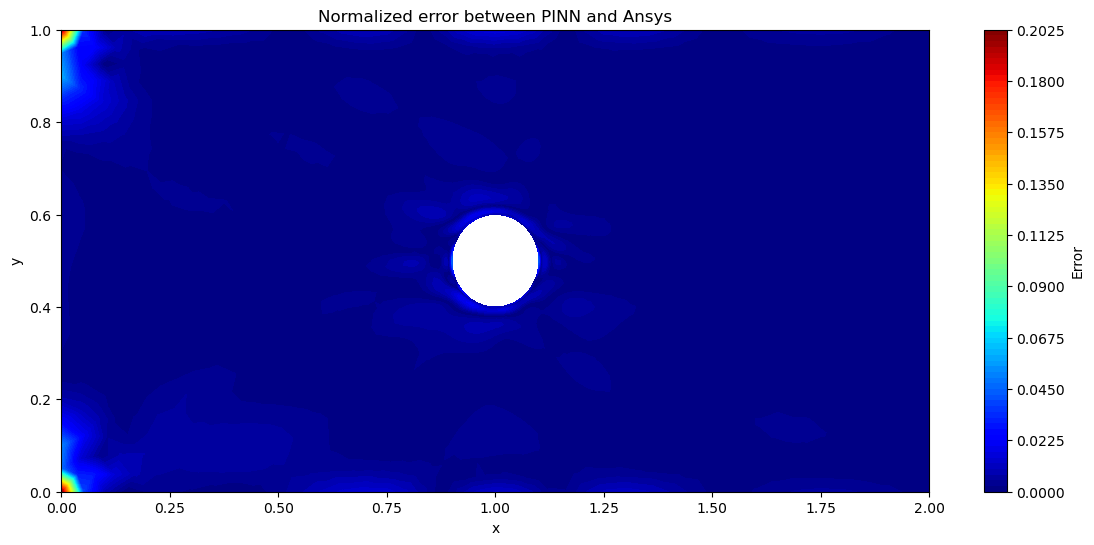

In [14]:
absolute_error = np.abs(von_mises - fem_von).flatten()
normalized_error = np.abs(von_mises - fem_von) / np.max(fem_von)

plt.figure(figsize=(14, 6))
plt.tricontourf(triang, normalized_error.flatten(), levels=100, cmap=color_map)
plt.title('Normalized error between PINN and Ansys')
cb = plt.colorbar()
cb.set_label("Error")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [15]:
sigma_max1 = np.max(von_mises)
sigma_max2 = np.max(fem_von)
print(sigma_max1)
print(sigma_max2)

k1 = sigma_max1 / sigma_0
k2 = sigma_max2 / sigma_0
print(k1)
print(k2)

157420350.0
158593650.0
3.148407
3.1718729
